In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import LNP, splineLNP, LNLN, splineLNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec
from rfest.plot import plot_subunits2d, plot_subunits3d, plot2d, plot3d, compare_LNP_and_LNLN

In [2]:
# The data source is changed so that the script for downloading the data no longer works.
# Please manually download it and put it into the `./data` folder.
data_mah = fetch_data(2)

(Maheswaranathan et. al. 2018) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


In [3]:
dims=[40, 50]
df = [9, 21]
dt = 0.01
n_samples = get_n_samples(20, dt) # 20 mins of the full dataset

stim = data_mah['stimulus'].T[:n_samples]
X = build_design_matrix(stim, dims[0])
y = data_mah['spike_counts'][7][:n_samples]


(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, y, dt, frac_train=0.5, frac_dev=0.1)

SUMMARY
               N    Minutes   Fraction
Total     120000       20.0        1.0
Train      60000       10.0        0.5
Dev        12000        2.0        0.1
Test       48000        8.0        0.4


In [4]:
r0_nospl_lnp = LNP(X_train, y_train, dims=dims, dt=dt)
r0_nospl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
            num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r0_spl_lnp = splineLNP(X_train, y_train, dims=dims, dt=dt, df=df)
r0_spl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
            num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r0_nospl_lnln = LNLN(X_train, y_train, dims=dims, dt=dt)
r0_nospl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=4, num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r0_spl_lnln = splineLNLN(X_train, y_train, dims=dims, dt=dt, df=df)
r0_spl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=4, num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	    11.353	  -370.601	   604.189	     0.193	     0.070
  300	    62.334	 -4816.912	  -152.317	     0.291	     0.126
Stop at 464 steps: cost (train) has been changing less than 1e-5 for 10 steps.

Total time elapsed: 91.914 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     1.078	   957.619	   186.925	     0.117	     0.081
  300	    11.695	 -3856.276	  -485.836	     0.249	     0.190
  600	    24.717	 -3918.595	  -498.298	     0.258	     0.198
  900	    37.872	 -3952.150	  -505.721	     0.264	     0.204
 1200	    50.539	 -3973.325	  -509.982	     0.268	     0.208
 1500	    63.643	 -3988.319	  -513.347	     0.271	     0.210
 1800	    76.403	 -3999.678	  -515.993	     0.273	     0.212
 2100	    89.171	 -4008.606	  -518.075	     0.274	     0.214
 2400	   102.048	 -4016.011	  -519.929	     0.276	     0.216
 2700	   115.251	 -4022.172	  -521.445	     0.277	     0.217
 3000	   127.982	 -4

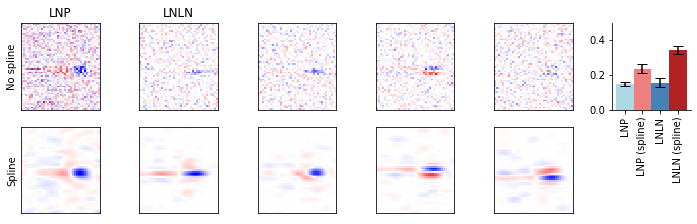

In [57]:
fig, ax = plt.subplots(2, 6, figsize=(12, 3.5))

w = uvec(r0_nospl_lnp.w_opt)
vmax = np.max([np.abs(w.max()), np.abs(w.min())])
ax[0, 0].imshow(uvec(r0_nospl_lnp.w_opt.reshape(dims).T), 
                cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax,
               aspect='auto')


w = uvec(r0_spl_lnp.w_opt.reshape(dims).T)
vmax = np.max([np.abs(w.max()), np.abs(w.min())])
ax[1, 0].imshow(uvec(r0_spl_lnp.w_opt.reshape(dims).T), 
                cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax,
               aspect='auto')

ws0 = uvec(r0_nospl_lnln.w_opt)
vmax0 = np.max([np.abs(ws0.max()), np.abs(ws0.min())])

ws1 = uvec(r0_spl_lnln.w_opt)
vmax1 = np.max([np.abs(ws1.max()), np.abs(ws1.min())])
for i in range(1, 5):
    ax[0, i].imshow(ws0[:, i-1].reshape(dims).T, 
                    cmap=plt.cm.bwr, vmin=-vmax0, vmax=vmax0,
                   aspect='auto')
    ax[1, i].imshow(ws1[:, i-1].reshape(dims).T, 
                    cmap=plt.cm.bwr, vmin=-vmax1, vmax=vmax1,
                   aspect='auto')
    
div = int(X_test.shape[0]/4)
cc_test = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m 
                     in [r0_nospl_lnp, r0_spl_lnp, r0_nospl_lnln, r0_spl_lnln]] for i
                     in range(4)])
cc_test_mean = cc_test.mean(0)
cc_test_std = cc_test.std(0)
x = [0, 1, 2, 3]
ax[0, -1].bar(x, cc_test_mean, yerr=cc_test_std, 
              width=1, 
              color=['lightblue', 'lightcoral', 'steelblue', 'firebrick'], 
              capsize=5)

labels = ['LNP', 'LNP (spline)', 'LNLN', 'LNLN (spline)']



ax = ax.flatten()
for i in range(len(ax)):
    if i == 5: 
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_ylim(0, 0.5)
        
    elif i == 11:
        ax[i].axis('off')
    else:    
        ax[i].set_xticks([])
        ax[i].set_yticks([])

ax[0].set_title('LNP')
ax[0].set_ylabel('No spline')


ax[1].set_title('LNLN')
ax[6].set_ylabel('Spline')

plt.subplots_adjust(wspace=0.5)

# fig.tight_layout()

fig.savefig('fig4a.pdf')

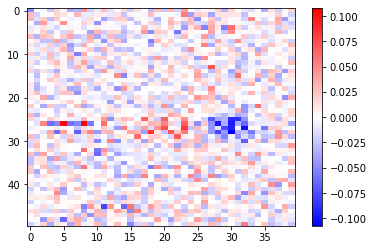

In [60]:
w = uvec(r0_nospl_lnp.w_opt)
vmax = np.max([np.abs(w.max()), np.abs(w.min())])
plt.imshow(uvec(r0_nospl_lnp.w_opt.reshape(dims).T), 
                cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax,
               aspect='auto')
plt.colorbar()
plt.savefig('Fig4_cbar.pdf')